> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

## Univariate CNN Single -Step
This tutorial is to demonstrate the process in build CNN for the Univariate Input ,Univariate Output for Single Step. It consists of 2 major part which are :

The Demostration of Building CNN using Synthetic data and Exercise of building CNN using shampoo-sales data. First, we will show the step in building the CNN :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Normalization and Batching the Data)
Step 2. Model Configuration for CNN<br>
Step 3. Train the model<br>
Step 4. Validate the model using graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>

First , let's us import the package needed

In [1]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
import math

In [2]:
# Data sequencing function for univariate input , univariate output , single step forecast

def univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

## Hyper parameter
Define the hyper parameter that need to tune the model

In [3]:
split_ratio = 0.70
num_epochs = 300
window_size = 5
batch_size = 1
learning_rate = 0.001
# seed
torch.manual_seed(123)

## Data Preparation
We create synthetic data to make sure the model is created correctly and having ability to perform the forecasting

In [4]:
# Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])

split_data = round(len(univariate_series) * split_ratio)
# split data by indexing
train_data = univariate_series[:split_data]
test_data = univariate_series[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Standardization
The data is scaled to mean = 0 , variance = 1

In [5]:
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_normalized = scaler.transform(train_data.reshape(-1, 1))

test_data_normalized = scaler.transform(test_data.reshape(-1, 1))

## Data Sequencing
Sequencing the data

In [6]:
trainX, trainY = univariate_single_step(train_data_normalized, window_size)
testX, testY = univariate_single_step(test_data_normalized, window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testX shape:{testY.shape}")

trainX shape:(23, 5, 1) trainY shape:(23, 1)

testX shape:(7, 5, 1) testX shape:(7, 1)


## Data Transform
Data need to transform from numpy to pytorch tensor before feed into the model then perform Data Transpose to make it can feed into CNN model

In [7]:
# transfrom to Pytorch tensor
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([23, 5, 1]) trainY shape:torch.Size([23, 1])

testX shape:torch.Size([7, 5, 1]) testY shape:torch.Size([7, 1])


## Data Transpose 

In [8]:
# trnaspose to suit CNN model
# Input: (N, C, L_in) in Conv1D
trainX = torch.transpose(trainX,1,2)
testX = torch.transpose(testX,1,2)

print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([23, 1, 5]) trainY shape:torch.Size([23, 1])

testX shape:torch.Size([7, 1, 5]) testY shape:torch.Size([7, 1])


## Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [9]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## CNN Configuration
The method use to create the model is call pytorch subclass method. It consists of 2 part where the first part is allow user to define the structure of the model such as number of convolution layer , pooling layer and the linear layer 

Second part of the method consist of forward() method , it allow user to control the flow of input data.For example , when the data pass in ,it will go throught the conv1 layer first then the output of conv1 layer will become the input for the ReLu activation function.The output of activation output will pass to the next pooling layer.

In [10]:
class CNN(nn.Module):

    def __init__(self,n_timeseries):
        super(CNN, self).__init__()
        
        self.n_timeseries = n_timeseries

        # Conv1d in_channels is base on num time series
        self.conv1 = nn.Conv1d(in_channels = n_timeseries, out_channels = 30, kernel_size = 2)
        
        # For example Input:(N,C,Lin) Output : (N,C,Lout)
        self.poo1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels = 30, out_channels = 20, kernel_size = 2)
        self.fc1 = nn.Linear(20, 10)
        self.fc2 = nn.Linear(10,1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.poo1(x)
        x = F.relu(self.conv2(x))
        # Flatten the data ,x.view(-1,a) , where a = input for next linear layer input
        x = x.view(-1,20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [11]:
# Input te attribute need by the model 
model = CNN(n_timeseries = trainX.shape[1] )
# Examine the model configuration 
print(model.eval())
# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [12]:
#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

## Training 

In [13]:
def training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape 
            y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0], train_Y.shape[1]))
            
            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()
            
            # Summing up the loss over each epoch
            running_loss_train += loss_train.item()
            
        # Average the loss base of the batch size
        epoch_loss_train = running_loss_train / len(train_X)
        
        # Store the averaged value
        train_loss[t] = epoch_loss_train

        # Validate the test data loss
        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to ensure the predicted output (y_test_pred) same size with test_y shape
                y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], test_Y.shape[1]))
                
                # Calculate the loss
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each epoch
                running_loss_valid += loss_test.item()
                
        # Average the loss base of the batch size
        epoch_loss_test = running_loss_valid / len(test_X)
        
        # Store the averaged value
        val_loss[t] = epoch_loss_test

    return train_loss, val_loss

In [14]:
# Start Training
train_loss, val_loss = training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

## Evaluation
A learning curve loss is plotted to define how well the data is fitting the model

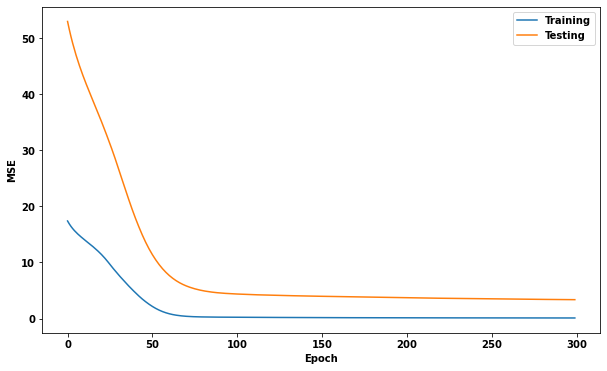

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
# position=range(len(train_loss))
# labels=range(1,len(train_loss)+1)
# plt.xticks(position, labels)
plt.legend()
plt.show()


## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data

In [16]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

In [17]:
# Section 2 : Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction, (y_train_prediction.shape[0], y_train_prediction.shape[1]))
trainY = torch.reshape(trainY, (trainY.shape[0], trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction, (y_test_prediction.shape[0], y_test_prediction.shape[1]))
testY = torch.reshape(testY, (testY.shape[0], testY.shape[1]))

In [18]:
# Section 3 : Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [19]:
# Examine the test data and forecast result 
print("Test Data \t Forecast Result")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

Test Data 	 Forecast Result
[330.]		[291.2049]
[340.]		[295.98517]
[350.]		[300.5763]
[360.]		[305.12878]
[370.]		[309.63947]
[380.]		[314.14166]
[390.]		[318.64386]


In [20]:
# Section 4 : Calculate the RMSE of train and test data
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.35 RMSE
Test Score: 56.02 RMSE


## Exercise for Univariate (Solution)
Use CNN to predict the temperature<br>
Data Sources :
This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.
The units are in degrees Celsius and there are 3650 observations. The source of the data is credited as the Australian Bureau of Meteorology.
https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

In [112]:
#Hyperparameter
num_epochs_temperature = 50
batch_size_temperature = 50
window_size_temperature = 5
learning_rate_temperature = 0.001

#seed
torch.manual_seed(123)

## Data Preparation

In [113]:
# Read the csv data 
temperature = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
temperature.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [114]:
temperature_ts = pd.Series(temperature['Temp'].values,
                             pd.date_range("1981-01-01",periods=len(temperature),freq='D'))

Text(0.5, 0, 'Year')

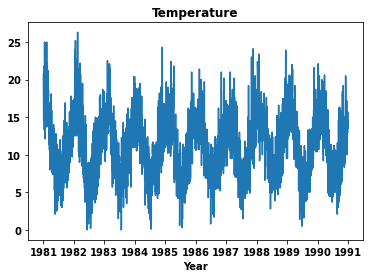

In [115]:
plt.plot(temperature_ts, label = 'temperature')
plt.title("Temperature")
plt.xlabel("Year")

## Data Splitting

In [152]:
# Create split data ratio
split_data = 30

In [153]:
# Split data by indexing 
train_data_temperature= temperature_ts[:-split_data]
test_data_temperature = temperature_ts[-split_data:]
train_time = temperature_ts.index[:-split_data]
test_time = temperature_ts.index[-split_data:]
print("train_data_shampoo_shape")
print(train_data_temperature.shape)
print("test_data_shampoo_shape")
print(test_data_temperature.shape)

train_data_shampoo_shape
(3620,)
test_data_shampoo_shape
(30,)


Text(0, 0.5, 'degrees Celsius')

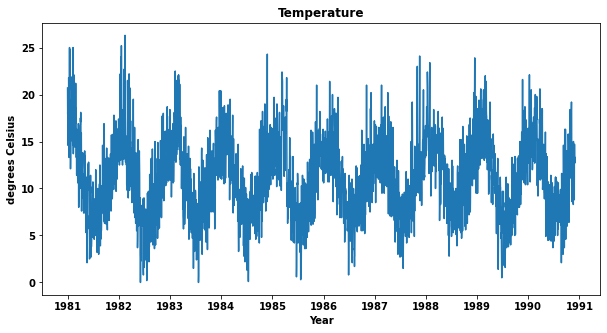

In [154]:
# Train Data Set
plt.figure(figsize=(10,5))
plt.plot(train_time,train_data_temperature)
plt.title("Temperature")
plt.xlabel("Year")
plt.ylabel("degrees Celsius")

Text(0, 0.5, 'degrees Celsius')

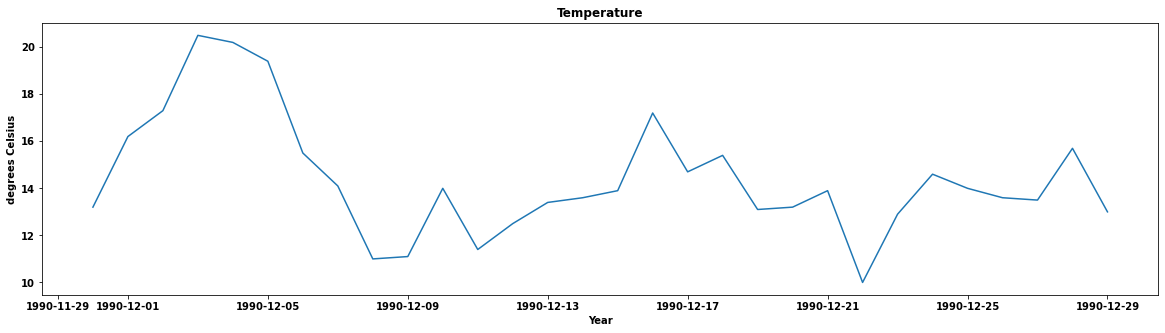

In [171]:
# Test Data Set
plt.figure(figsize=(20,5))
plt.plot(test_time,test_data_temperature)
plt.title("Temperature")
plt.xlabel("Year")
plt.ylabel("degrees Celsius")

## Data Standardization

Reshape need to be done due to the scaler only take in vector format of data before standardization

In [156]:
#Reshape before normalize
train_data_temperature = train_data_temperature.values.reshape(-1, 1)
test_data_temperature = test_data_temperature.values.reshape((-1, 1))

#Build Scaler
scaler_temperature = StandardScaler().fit(train_data_temperature)
train_data_normalized_temperature = scaler_temperature.transform(train_data_temperature)

test_data_normalized_temperature = scaler_temperature.transform(test_data_temperature)

## Data Seqeuncing

In [157]:
trainX_temperature ,trainY_temperature =  univariate_single_step(train_data_normalized_temperature,window_size_temperature)
testX_temperature , testY_temperature = univariate_single_step(test_data_normalized_temperature,window_size_temperature)
print(f"trainX shape:{trainX_temperature.shape} trainY shape:{trainY_temperature.shape}\n")
print(f"testX shape:{testX_temperature.shape} testX shape:{testY_temperature.shape}")

trainX shape:(3615, 5, 1) trainY shape:(3615, 1)

testX shape:(25, 5, 1) testX shape:(25, 1)


## Data Transform
Transfrom numpy to Pytorch tensor  

In [158]:
# make training and test sets in torch
trainX_temperature = torch.from_numpy(trainX_temperature).type(torch.Tensor)
trainY_temperature = torch.from_numpy(trainY_temperature).type(torch.Tensor)
testX_temperature = torch.from_numpy(testX_temperature).type(torch.Tensor)
testY_temperature = torch.from_numpy(testY_temperature).type(torch.Tensor)
print(f"trainX shape:{trainX_temperature.shape} trainY shape:{trainY_temperature.shape}\n")
print(f"testX shape:{testX_temperature.shape} testX shape:{testY_temperature.shape}")

trainX shape:torch.Size([3615, 5, 1]) trainY shape:torch.Size([3615, 1])

testX shape:torch.Size([25, 5, 1]) testX shape:torch.Size([25, 1])


## Data Transpose 

In [159]:
# Transpose to suit CNN
# Input: (N, C, L_in) in Conv1D
trainX = torch.transpose(trainX_temperature,1,2)
testX = torch.transpose(testX_temperature,1,2)

print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([3615, 1, 5]) trainY shape:torch.Size([23, 1])

testX shape:torch.Size([25, 1, 5]) testY shape:torch.Size([7, 1])


## Data Iterator

In [160]:
# Create Iterator
train_dataset_temperature = TensorDataset(trainX, trainY_temperature)
train_iter_temperature = DataLoader(train_dataset_temperature,batch_size=batch_size_temperature,shuffle=False)

test_dataset_temperature = TensorDataset(testX, testY_temperature)
test_iter_temperature = DataLoader(test_dataset_temperature,batch_size=batch_size_temperature,shuffle=False)

## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [161]:
# Input te attribute need by the model 
model_temperature= CNN(n_timeseries = trainX.shape[1])
# Examine the model configuration 
print(model_temperature.eval())
# Define Adam as optimizer
optimizer_temperature= torch.optim.Adam(model_temperature.parameters(), lr=learning_rate_temperature)
# Define MSE as loss function
loss_fn_temperature = nn.MSELoss()

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [162]:
# Xavier weight intialization
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model_temperature.apply(weights_init)

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

In [163]:
# Start Training 
train_loss_temperature,val_loss_temperature = training(num_epochs_temperature,train_iter_temperature,test_iter_temperature,optimizer_temperature,loss_fn_temperature,model_temperature)

## Evaluate
Plot the learning curve to evaluate the loss of each epoch 

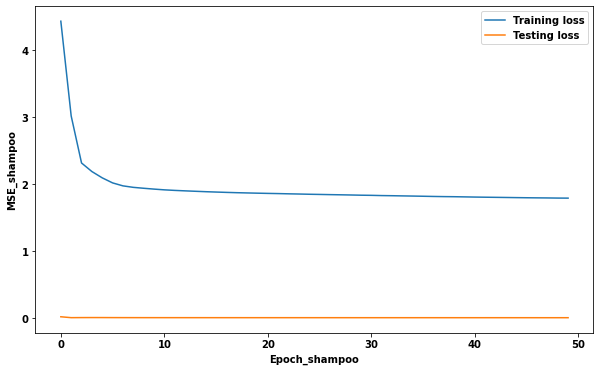

In [164]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_temperature, label="Training loss")
plt.plot(val_loss_temperature, label="Testing loss")
plt.xlabel("Epoch_shampoo")
plt.ylabel("MSE_shampoo")
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data<br>

In [165]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction_temperature= model_temperature(trainX)
    y_test_prediction_temperature= model_temperature(testX)

# Section 2 : Reshape to original data
y_train_prediction_temperature = torch.reshape(y_train_prediction_temperature,(y_train_prediction_temperature.shape[0],y_train_prediction_temperature.shape[1]))
trainY_temperature= torch.reshape(trainY_temperature,(trainY_temperature.shape[0],trainY_temperature.shape[1]))
y_test_prediction_temperature = torch.reshape(y_test_prediction_temperature,(y_test_prediction_temperature.shape[0],y_test_prediction_temperature.shape[1]))
testY_temperature= torch.reshape(testY_temperature,(testY_temperature.shape[0],testY_temperature.shape[1]))

In [166]:
# Section 3 : Invert predictions
y_train_pred_temperature = scaler_temperature.inverse_transform(y_train_prediction_temperature.detach().numpy())
y_train_temperature= scaler_temperature.inverse_transform(trainY_temperature.detach().numpy())
y_test_pred_temperature= scaler_temperature.inverse_transform(y_test_prediction_temperature.detach().numpy())
y_test_temperature= scaler_temperature.inverse_transform(testY_temperature.detach().numpy())

In [167]:
# Examine the test data and forecast result 
print("Test Data \tForecast Result")
for i in range(len(y_test_temperature)):
    print(f"{y_test_temperature[i]}\t\t{y_test_pred_temperature[i]}")

Test Data 	Forecast Result
[19.4]		[17.803673]
[15.5]		[17.77551]
[14.1]		[15.826288]
[11.]		[13.960919]
[11.1]		[12.671794]
[14.]		[12.074784]
[11.4]		[13.853307]
[12.5]		[11.9201975]
[13.4]		[11.837008]
[13.6]		[13.489348]
[13.9]		[13.461517]
[17.2]		[13.964194]
[14.7]		[15.919822]
[15.400001]		[14.558834]
[13.1]		[14.497311]
[13.2]		[14.145282]
[13.9]		[13.466012]
[10.]		[14.432797]
[12.9]		[11.678817]
[14.6]		[12.855976]
[14.]		[14.056385]
[13.6]		[13.186731]
[13.5]		[13.595618]
[15.7]		[14.005142]
[13.]		[15.47737]


In [168]:
#calculate root mean squared error for the train and test data
trainScore_temperature = math.sqrt(mean_squared_error(y_train_temperature[:,0], y_train_pred_temperature[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_temperature))
testScore_temperature = math.sqrt(mean_squared_error(y_test_temperature[:,0], y_test_pred_temperature[:,0]))
print('Test Score: %.2f RMSE' % (testScore_temperature))

Train Score: 2.46 RMSE
Test Score: 1.83 RMSE


## Plot the Forecast Result 

In [169]:
# Adjust to make the sequence data plot on original test data 
test_time_modification = pd.to_datetime(test_time)
start_date=test_time_modification[0]+pd.Timedelta(window_size_temperature, unit='D')
date_range = pd.Series(pd.date_range(start_date,freq="D",periods=len(y_test_temperature)))


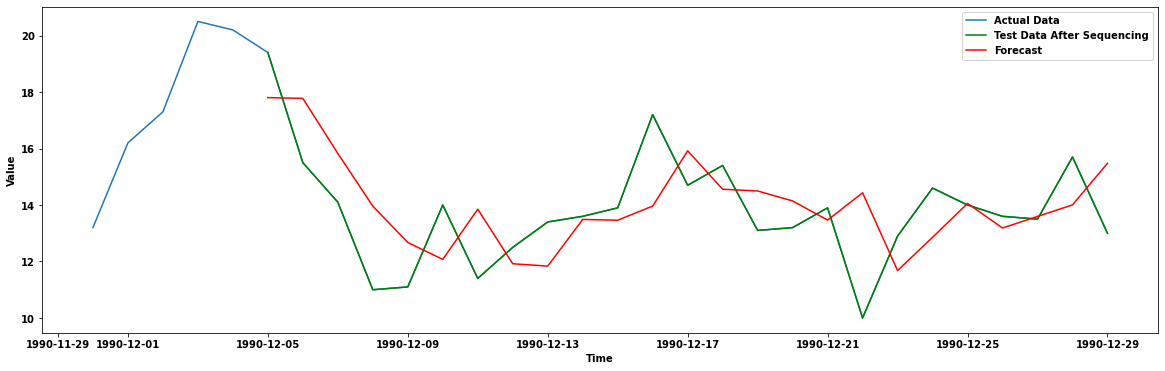

In [170]:
# Plot the forecast result
plt.figure(figsize=(20,6))
plt.plot(test_time,test_data_temperature, label = 'Actual Data')
plt.plot(date_range,y_test_temperature, color="green",label = 'Test Data After Sequencing')
plt.plot(date_range,y_test_pred_temperature,color="red", label = 'Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

## Reference 
1. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
2. [[CNN]Time-series Forecasting with Pytorch](https://www.kaggle.com/hanjoonchoe/cnn-time-series-forecasting-with-pytorch)